In [323]:
!pip install statsforecast
!pip install pmdarima
!pip install prophet

In [324]:
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, SimpleExponentialSmoothingOptimized, Holt, HoltWinters, DynamicOptimizedTheta
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from prophet import Prophet

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import pmdarima as pm
import seaborn as sns
import pandas as pd
import numpy as np
import pylab
import math

#UNIVARIATE

#1. DATA ACQUISTION

In [325]:
#Uploaded the file from drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [326]:
#Read the CSV file
file_path = "/content/drive/MyDrive/TSA/household_power_consumption.txt"  # Update with the actual path of your CSV file

#Read the CSV and parse dates
df = pd.read_csv(file_path, sep=';',parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True, index_col='DateTime')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


#2. DATA PREPROCESSING

In [327]:
'''
    Convert specified columns in a DataFrame to numeric, handling errors by setting them to NaN.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): List of column names to be converted to numeric.

    Returns:
    pd.DataFrame: The DataFrame with specified columns converted to numeric.
'''

numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')



# Check and display the number of missing values in each column after conversion
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

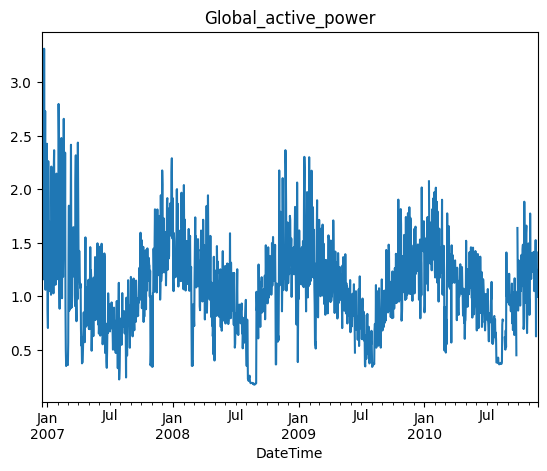

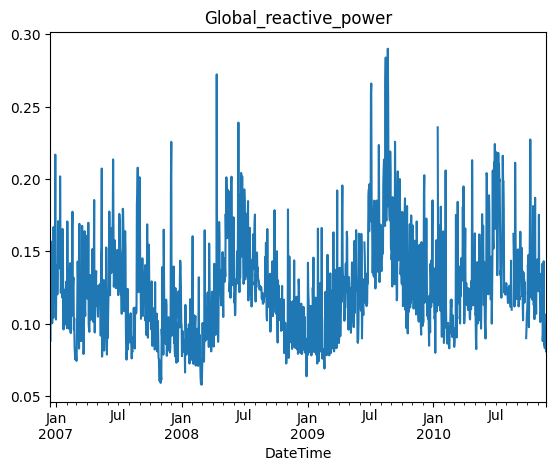

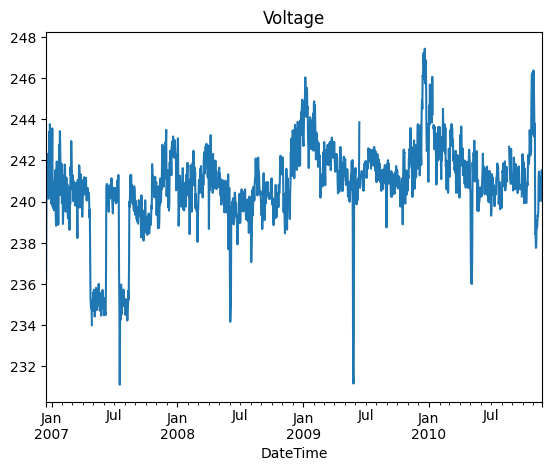

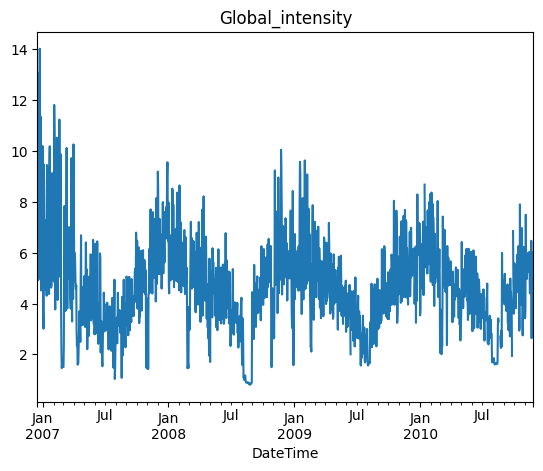

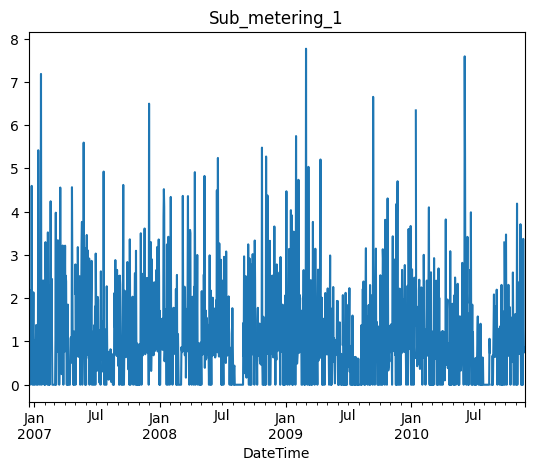

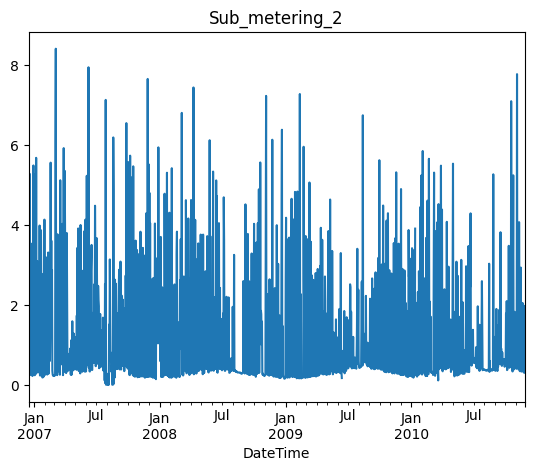

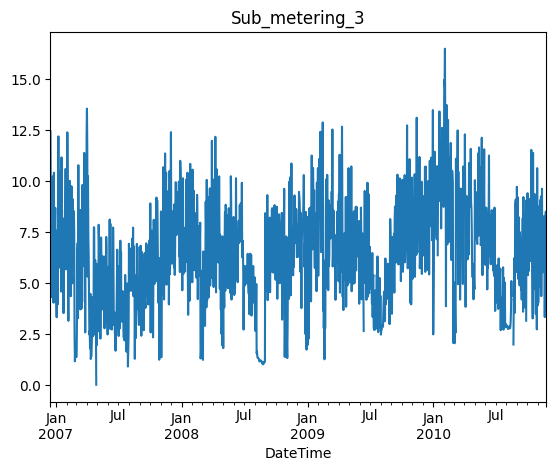

In [328]:
def plot_all_columns(time_series_df, rule='D'):
    """
    Plot each numeric column in a time series DataFrame after resampling.

    Args:
    time_series_df (pd.DataFrame): The DataFrame containing the time series data.
    rule (str): The resampling rule (e.g., 'D' for daily, 'M' for monthly).

    Returns:
    None
    """
    # Loop through each column in the DataFrame that is of type float64
    for c in time_series_df.select_dtypes(include=['float64']):

        # Resample the column data according to the given rule and calculate the mean
        # Plot the resampled data with the column name as the title
        time_series_df[c].resample(rule=rule).mean().plot(title=c)

        # Display the plot
        plt.show()
        print()

# Call the function to plot all columns in the DataFrame
plot_all_columns(df)


In [329]:
#Resampling dataframe to daily frequency and computing mean.
df_daily = df.resample(rule='D').mean()

In [330]:
#Checking for null values
df_daily.isna().sum()

Global_active_power      9
Global_reactive_power    9
Voltage                  9
Global_intensity         9
Sub_metering_1           9
Sub_metering_2           9
Sub_metering_3           9
dtype: int64

In [331]:
#Displaying the rows with null values.
mask = df_daily['Global_reactive_power'].isnull()
df_daily[mask]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2007-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
#Used forward-fill method to handle the null values.
df_daily = df_daily.ffill()
df_daily.isnull().sum()
df_daily[mask]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2007-04-29,1.082762,0.136190,233.986190,4.638095,0.000000,0.857143,0.000000
2009-06-14,0.473933,0.130600,243.852667,2.006667,0.000000,0.166667,2.633333
2010-01-13,1.436213,0.148179,244.251221,5.976260,0.618141,3.907055,10.715566
2010-08-18,0.775120,0.109632,240.992171,3.292710,0.744849,0.587163,4.348653
2010-08-19,0.775120,0.109632,240.992171,3.292710,0.744849,0.587163,4.348653
2010-08-20,0.775120,0.109632,240.992171,3.292710,0.744849,0.587163,4.348653
2010-08-21,0.775120,0.109632,240.992171,3.292710,0.744849,0.587163,4.348653
2010-09-26,0.449178,0.120864,240.775127,1.942373,0.000000,0.635593,3.796610
2010-09-27,0.449178,0.120864,240.775127,1.942373,0.000000,0.635593,3.796610


In [333]:
#Redisplaying the values to check whether the null values have been handled correctly.
df_daily.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

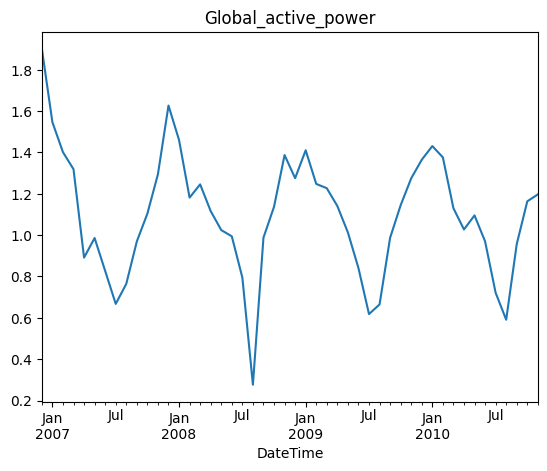

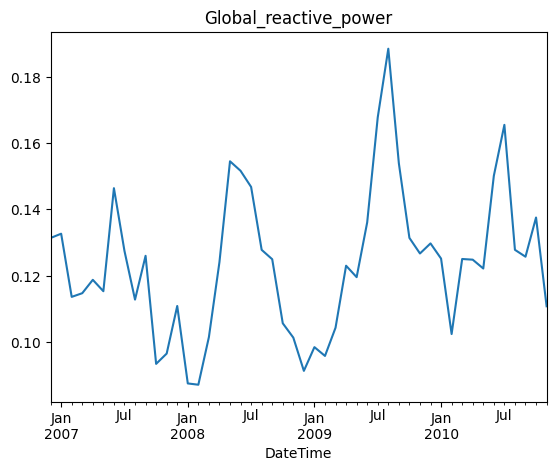

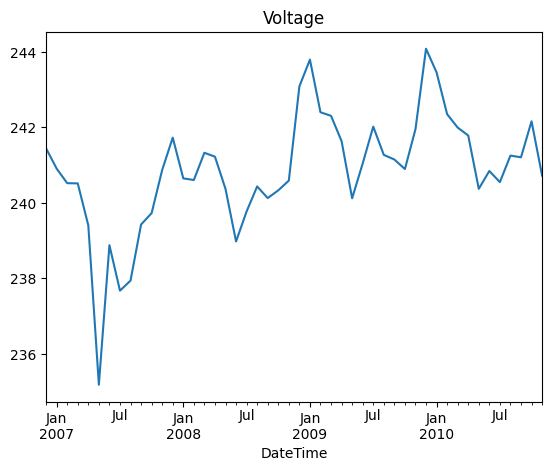

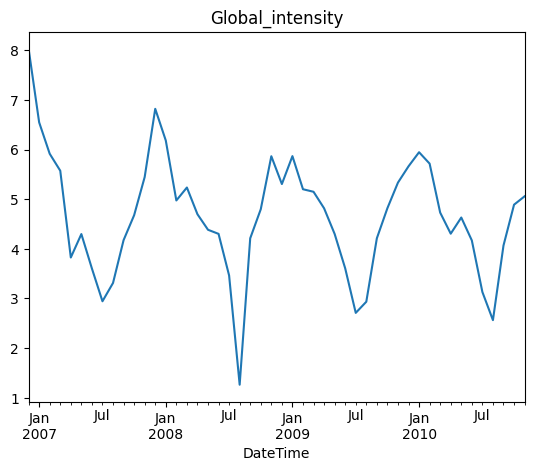

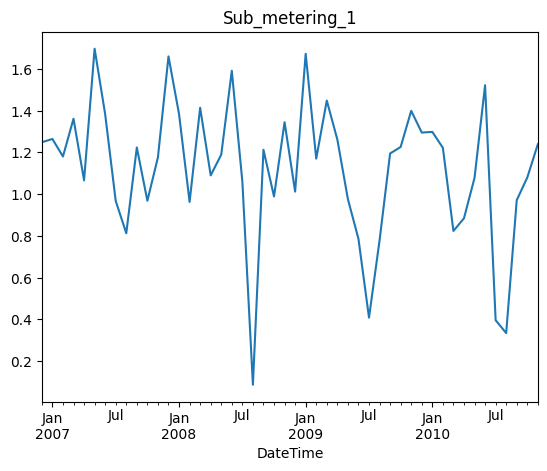

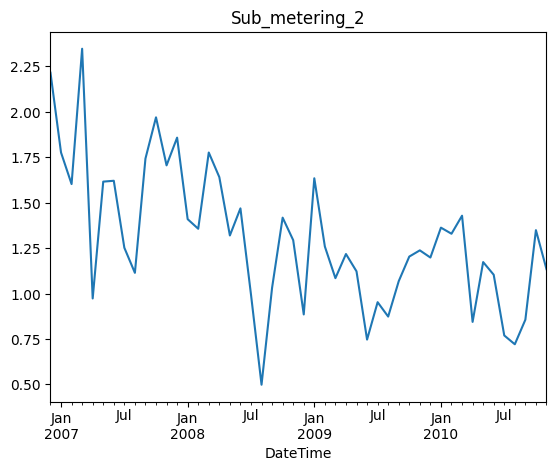

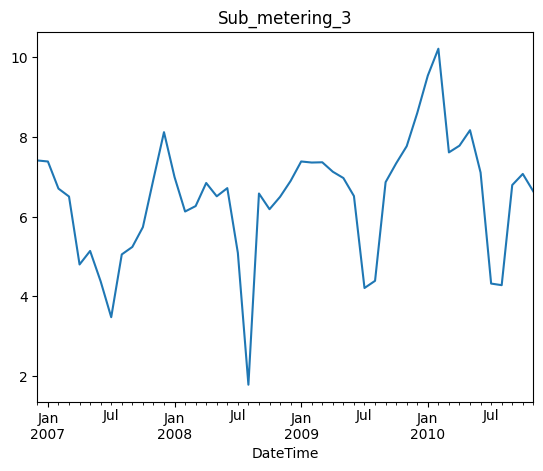

In [334]:
#Plotting the monthly time series to check for more correct visualization.
plot_all_columns(df, rule='M')
print()

In [335]:
# Resample the column data according to the given rule and calculate the mean for monthly data(Scaling to monthly).
df_monthly = df.resample(rule='M').mean()

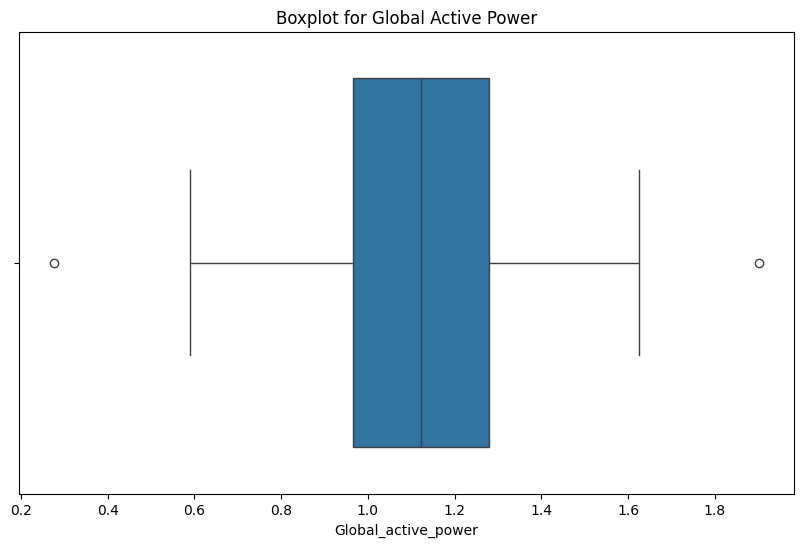

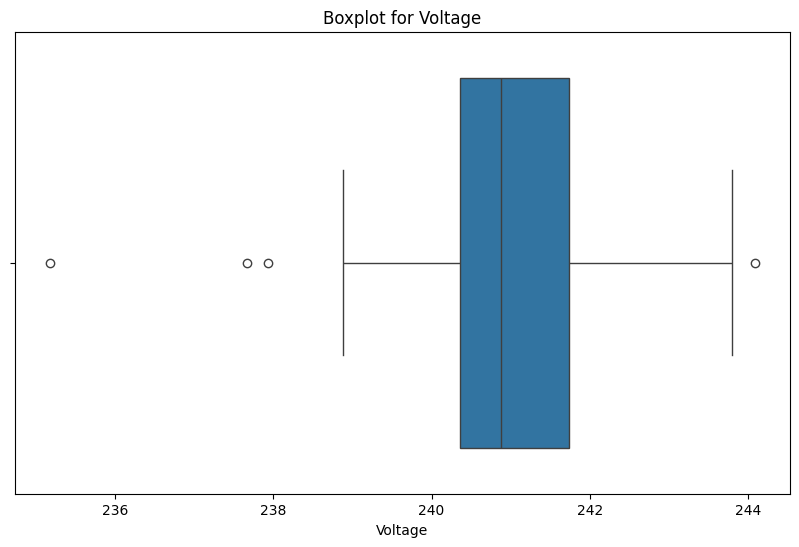

In [336]:
def plot_boxplots(df):
    """
    Plot boxplots to detect outliers in specified columns of the DataFrame.

    Args:
    df: The DataFrame containing the data.

    Returns:
    None
    """
    # Boxplot for Global Active Power
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['Global_active_power'])
    plt.title('Boxplot for Global Active Power')
    plt.show()

    print()

    # Boxplot for Voltage
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['Voltage'])
    plt.title('Boxplot for Voltage')
    plt.show()

# Call the function to plot boxplots for df_monthly
plot_boxplots(df_monthly)


In [337]:
#Calculate the first and third quarter.
Q1 = df_monthly['Global_active_power'].quantile(0.25)
Q3 = df_monthly['Global_active_power'].quantile(0.75)

# Compute the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find the outliers in Global Active Power based on the defined bounds
outliers_ga = df_monthly[(df_monthly['Global_active_power'] < lower_bound) | (df_monthly['Global_active_power'] > upper_bound)]

# Print the number of outliers detected
print(f"Number of outliers in Global Active Power: {len(outliers_ga)}")

# Calculate the percentage of data points that are outliers
outlier_percentage = (len(outliers_ga) / len(df_monthly)) * 100

# Print the percentage of outliers
print(f"Outliers constitute {outlier_percentage:.2f}% of the data.")


Number of outliers in Global Active Power: 2
Outliers constitute 4.17% of the data.


#3. EXPLORATORY DATA ANALYSIS

<Axes: xlabel='DateTime'>

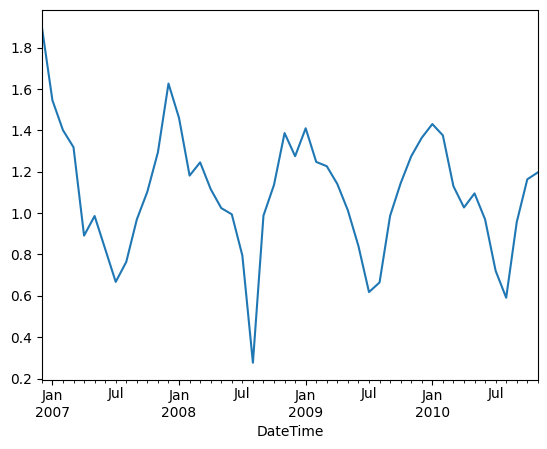

In [338]:
#Plot for global active power for monthly after scaling.
df_monthly['Global_active_power'].plot()

In [339]:
#Rechecking whether there are any null values or not.
df_monthly.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [340]:
#Displaying the first few values.
df_monthly['Global_active_power'].head()

DateTime
2006-12-31    1.901295
2007-01-31    1.546034
2007-02-28    1.401084
2007-03-31    1.318627
2007-04-30    0.891189
Freq: M, Name: Global_active_power, dtype: float64

In [341]:
#Displaying the last few values.
df_monthly['Global_active_power'].tail()

DateTime
2010-07-31    0.721068
2010-08-31    0.590778
2010-09-30    0.956442
2010-10-31    1.163399
2010-11-30    1.196854
Freq: M, Name: Global_active_power, dtype: float64

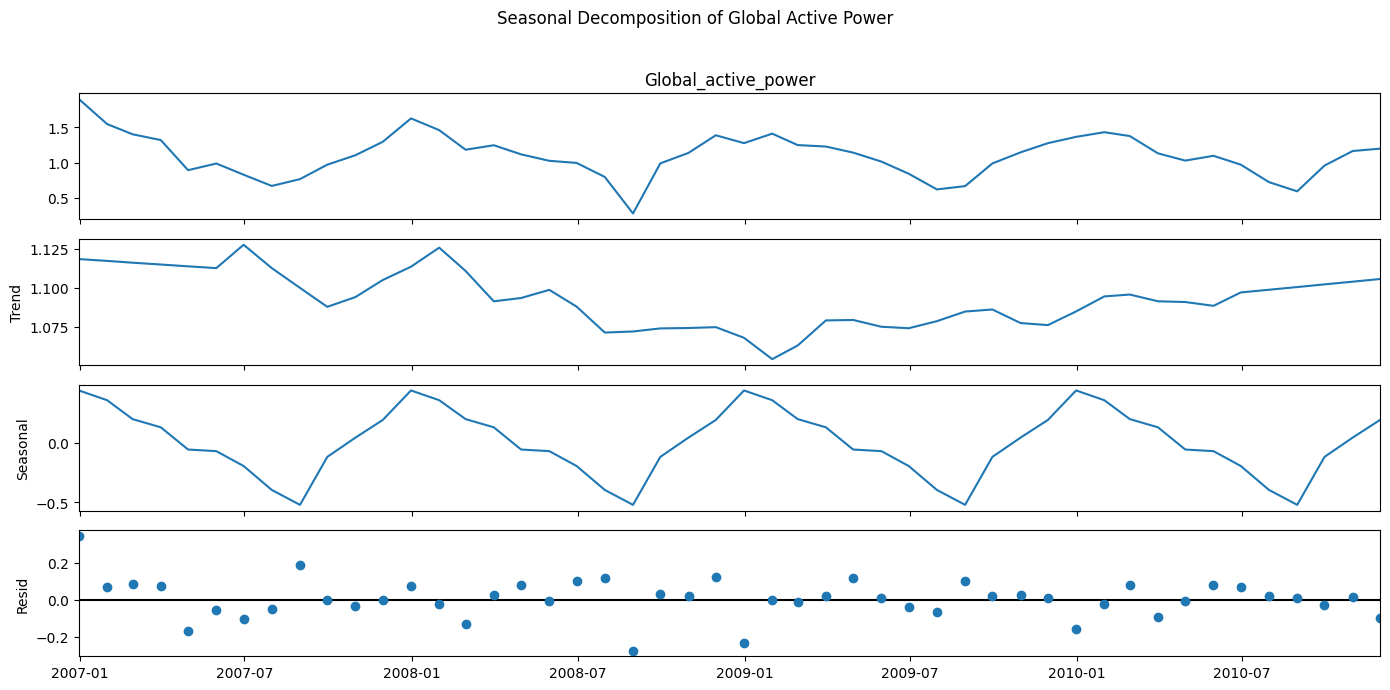

In [342]:
def decompose_time_series(df, column):
    """
    Decompose the time series data into trend, seasonal, and residual components.

    Args:
    df: The DataFrame containing the time series data.
    column (str): The name of the column to decompose.

    Returns:
    None
    """
    # Decompose the time series data using seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(df[column], model='additive', extrapolate_trend='freq')

    # Plot the decomposed components
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)  # Set the figure size
    fig.suptitle('Seasonal Decomposition of Global Active Power')  # Set the main title
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

# Assuming 'df_monthly' is your DataFrame with monthly averages of 'Global_active_power' and it's indexed by DateTime

# Call the function to decompose the time series and plot the components
decompose_time_series(df_monthly, 'Global_active_power')


In [343]:
def print_and_plot_acf(time_series):
    """
    Print and plot the Autocorrelation Function (ACF) for a given time series.

    Args:
    time_series: The time series data to analyze.

    Returns:
    None
    """
    #Print the ACF values up to lag 13
    print(sm.tsa.stattools.acf(time_series, nlags=13))

    #Plotting the ACF values up to lag 13
    sm.graphics.tsa.plot_acf(time_series, lags=13)

    # Show the plot
    plt.show()

def print_and_plot_pacf(time_series):
    """
    Print and plot the Partial Autocorrelation Function (PACF) for a given time series.

    Args:
    time_series: The time series data to analyze.

    Returns:
    None
    """
    #Print the PACF values up to lag 16
    print(sm.tsa.stattools.pacf(time_series, nlags=16))

    #Plottong the PACF values up to lag 16
    sm.graphics.tsa.plot_pacf(time_series, lags=16)

    #Show the plot
    plt.show()


[ 1.          0.64699225  0.29680957 -0.02960347 -0.31601166 -0.50429647
 -0.57499433 -0.56582161 -0.38942082 -0.06233935  0.25236882  0.49695209
  0.63108181  0.49073642]


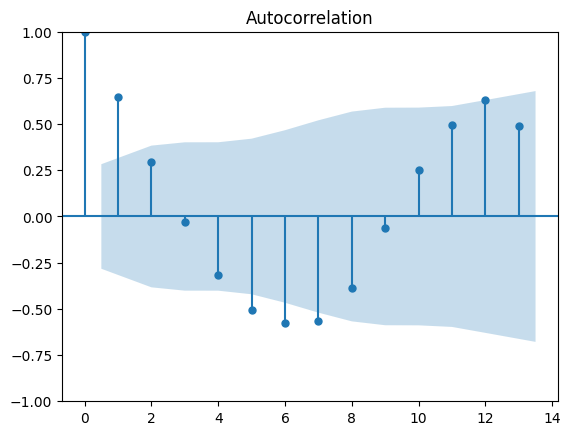

In [344]:
#Display the auto-correlation function
print_and_plot_acf(df_monthly['Global_active_power'])

[ 1.          0.66075804 -0.22521677 -0.24961445 -0.29681252 -0.27450545
 -0.28129299 -0.40795463 -0.26305612  0.01032746  0.09495196  0.2779163
  0.53031516  0.18454001 -0.18142735 -0.13220102 -0.04694419]


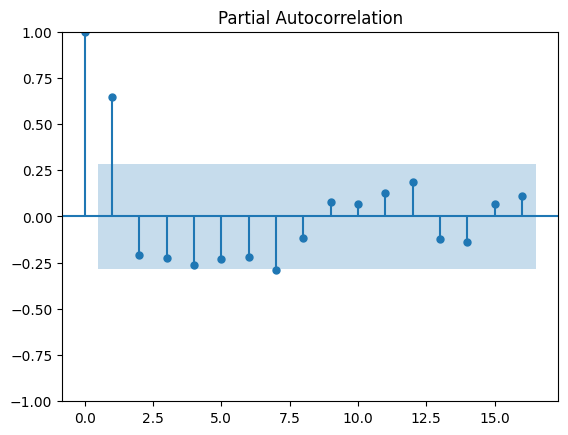

In [345]:
#Display the partial-autocorrelation
print_and_plot_pacf(df_monthly['Global_active_power'])

In [346]:
def test_stationarity(timeseries):
    """
    Perform the Augmented Dickey-Fuller test to check the stationarity of a time series.

    Args:
    timeseries: The time series data to test for stationarity.

    Returns:
    None
    """
    #Running the Augmented Dickey-Fuller test on the time series, dropping any NaN values
    result = adfuller(timeseries.dropna())

    #Printing the ADF statistic
    print('ADF Statistic: %f' % result[0])

    #Printing the p-value
    print('p-value: %f' % result[1])

    #Printing the critical values for different confidence levels
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

#Testing stationarity
test_stationarity(df_monthly['Global_active_power'])


ADF Statistic: -4.897270
p-value: 0.000035
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


Since the p-value is 0.000035 which is very small so we will reject null hypothesis. Hence the time series is stationary.

#4. TIME SERIES MODELING

In [347]:
#Extracting the 'Global_active_power' column and reset the index
series = df_monthly['Global_active_power'].reset_index()

#Adding a new column 'unique_id' with a constant value of 1 for each row
series["unique_id"] = 1

#Renaming the columns to 'ds' for the date, 'y' for the values, and 'unique_id' for the identifier
series.columns = ["ds", "y", "unique_id"]

#Displaying the first few rows
series.head()

,ds,y,unique_id
0,2006-12-31,1.901295,1
1,2007-01-31,1.546034,1
2,2007-02-28,1.401084,1
3,2007-03-31,1.318627,1
4,2007-04-30,0.891189,1


In [348]:
#Converting the 'ds' column to datetime format with the specified format ⁠
series["ds"] = pd.to_datetime(series["ds"],format="%b-%y")

In [349]:
#Displaying few values
series.head()

,ds,y,unique_id
0,2006-12-31,1.901295,1
1,2007-01-31,1.546034,1
2,2007-02-28,1.401084,1
3,2007-03-31,1.318627,1
4,2007-04-30,0.891189,1


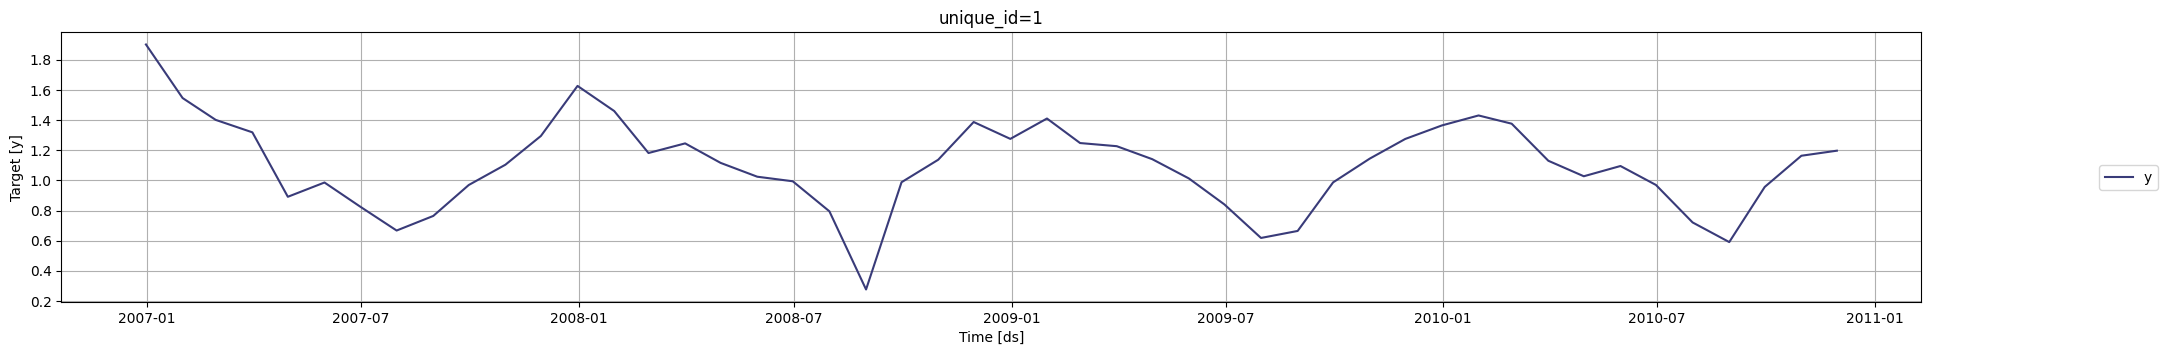

In [350]:
#Displaying our original time-series plot
StatsForecast.plot(series)

In [351]:
# Splitting data into train data and test data.

#First 3 years for train
train_df = series.iloc[:-12]

#Last year for test data
test_df = series.iloc[-12:]



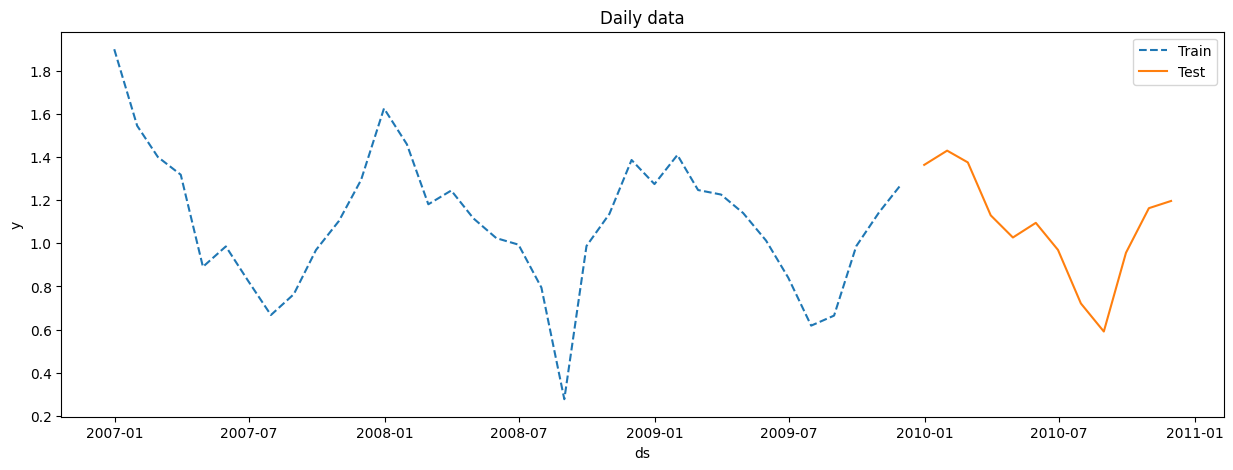

In [352]:
#Plotting the training and test data using seaborn
plt.figure(figsize=(15, 5))

#Plotting the training data with dashed lines
sns.lineplot(data=train_df, x="ds", y="y", label="Train", linestyle="--")

#Plotting the testing data
sns.lineplot(data=test_df, x="ds", y="y", label="Test")

#Adding a title to the plot
plt.title("Daily data")

#Displaying plot
plt.show()


In [353]:
#Forecast horizon = number of months that we want to forecast into the future
horizon = len(test_df)
horizon

12

In [354]:
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, SimpleExponentialSmoothingOptimized, Holt, HoltWinters, DynamicOptimizedTheta

#Append different models to list
models = []


models.append(HistoricAverage(alias="Average"))
models.append(Naive(alias="Naive"))
models.append(RandomWalkWithDrift(alias="Drift"))
models.append(SeasonalNaive(season_length=12, alias="SeasonalNaive"))
models.append(SimpleExponentialSmoothingOptimized(alias = "SESOpt"))
models.append(Holt(alias = "Holt"))
models.append(HoltWinters(season_length=12, alias = "HoltWinters"))
models.append(DynamicOptimizedTheta(season_length=12, decomposition_type="additive", alias="Theta"))

In [355]:
models

[Average, Naive, Drift, SeasonalNaive, SESOpt, Holt, HoltWinters, Theta]

In [356]:
# Initializing the StatsForecast object with the training dataFrame, models, and other parameters
sf = StatsForecast(df=train_df,
                   models=models,
                   freq='M', # monthly frequency
                   n_jobs=-1)

In [357]:
#Fitting the models
sf.fit()

StatsForecast(models=[Average,Naive,Drift,SeasonalNaive,SESOpt,Holt,HoltWinters,Theta])

In [358]:
#See fitted values from the models
result_avg = sf.fitted_[0,0].model_
result_naive = sf.fitted_[0,1].model_
result_drift = sf.fitted_[0,2].model_
result_snaive = sf.fitted_[0,3].model_
result_sesopt = sf.fitted_[0,4].model_
result_holt = sf.fitted_[0,5].model_
result_holtwinters = sf.fitted_[0,6].model_
result_theta = sf.fitted_[0,7].model_

In [359]:
fitted_df = pd.DataFrame()

fitted_df["fitted_avg"] = result_avg.get("fitted")
fitted_df["fitted_naive"] = result_naive.get("fitted")
fitted_df["fitted_drift"] = result_drift.get("fitted")
fitted_df["fitted_snaive"] = result_snaive.get("fitted")
fitted_df["fitted_sesopt"] = result_sesopt.get("fitted")
fitted_df["fitted_holt"] = result_holt.get("fitted")
fitted_df["fitted_holtwinters"] = result_holtwinters.get("fitted")
fitted_df["fitted_theta"] = result_theta.get("fitted")

#Also have the timestamp
fitted_df["ds"]=series["ds"]

In [360]:
#See the first 5 rows
fitted_df.head()

,fitted_avg,fitted_naive,fitted_drift,fitted_snaive,fitted_sesopt,fitted_holt,fitted_holtwinters,fitted_theta,ds
0,1.103978,NaN,NaN,NaN,NaN,1.901614,1.623474,1.901295,2006-12-31
1,1.103978,1.901295,1.883394,NaN,1.901295,1.644166,1.499045,1.891789,2007-01-31
2,1.103978,1.546034,1.528132,NaN,1.549587,1.340333,1.307316,1.549491,2007-02-28
3,1.103978,1.401084,1.383182,NaN,1.402569,1.236513,1.289752,1.402568,2007-03-31
4,1.103978,1.318627,1.300726,NaN,1.319466,1.186974,1.095486,1.319466,2007-04-30


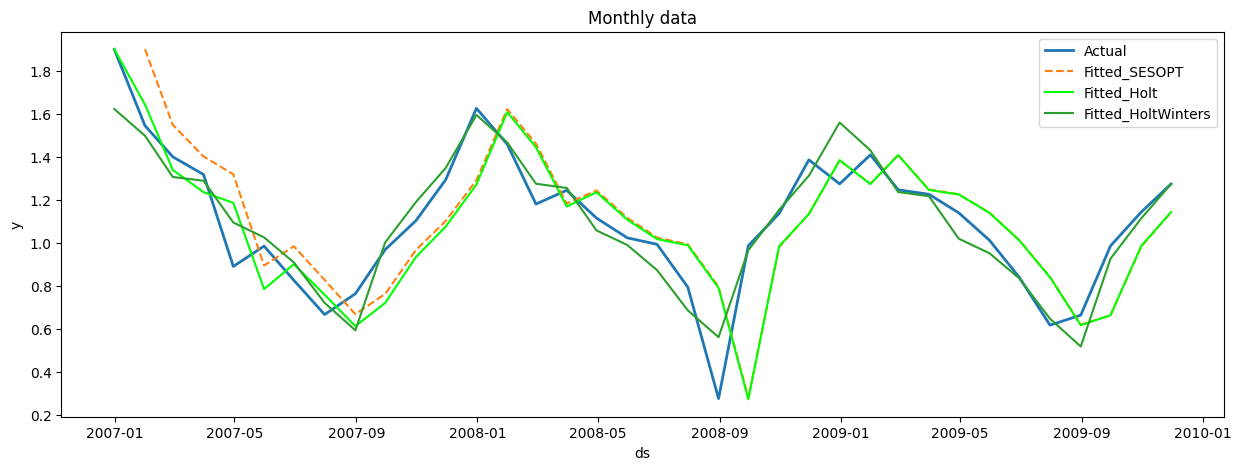

In [361]:
#Plot the actuals vs. fitted values for all SES Optimized, Holt's and Holt-Winter's models
plt.figure(figsize=(15,5))

#Actual data
sns.lineplot(data=train_df, x="ds", y="y", label="Actual", linewidth=2)

#SES Optimized model fitted values
sns.lineplot(data=fitted_df,x="ds", y="fitted_sesopt", label="Fitted_SESOPT", linestyle="--", )

#Holt's model fitted values
sns.lineplot(data=fitted_df, x="ds", y="fitted_holt", label="Fitted_Holt", color="lime")

#Holt-Winter's model fitted values
sns.lineplot(data=fitted_df, x="ds", y="fitted_holtwinters", label="Fitted_HoltWinters")


#Add title and show
plt.title("Monthly data");
plt.show()

In [362]:
# Generating Forecast using StatsForecast Object
Y_hat = sf.forecast(h=horizon, fitted=True)
Y_hat.head()

,ds,Average,Naive,Drift,SeasonalNaive,SESOpt,Holt,HoltWinters,Theta
unique_id,,,,,,,,,
1,2009-12-31,1.103978,1.274743,1.256842,1.275189,1.273425,1.274650,1.520112,1.273425
1,2010-01-31,1.103978,1.274743,1.238940,1.410202,1.273425,1.274570,1.394534,1.273425
1,2010-02-28,1.103978,1.274743,1.221039,1.247568,1.273425,1.274506,1.202213,1.273425
1,2010-03-31,1.103978,1.274743,1.203138,1.226735,1.273425,1.274454,1.183850,1.273425
1,2010-04-30,1.103978,1.274743,1.185236,1.140690,1.273425,1.274413,0.988345,1.273425


In [363]:
#Resetting the index
Y_hat=Y_hat.reset_index()
Y_hat.head()

,unique_id,ds,Average,Naive,Drift,SeasonalNaive,SESOpt,Holt,HoltWinters,Theta
0,1,2009-12-31,1.103978,1.274743,1.256842,1.275189,1.273425,1.274650,1.520112,1.273425
1,1,2010-01-31,1.103978,1.274743,1.238940,1.410202,1.273425,1.274570,1.394534,1.273425
2,1,2010-02-28,1.103978,1.274743,1.221039,1.247568,1.273425,1.274506,1.202213,1.273425
3,1,2010-03-31,1.103978,1.274743,1.203138,1.226735,1.273425,1.274454,1.183850,1.273425
4,1,2010-04-30,1.103978,1.274743,1.185236,1.140690,1.273425,1.274413,0.988345,1.273425


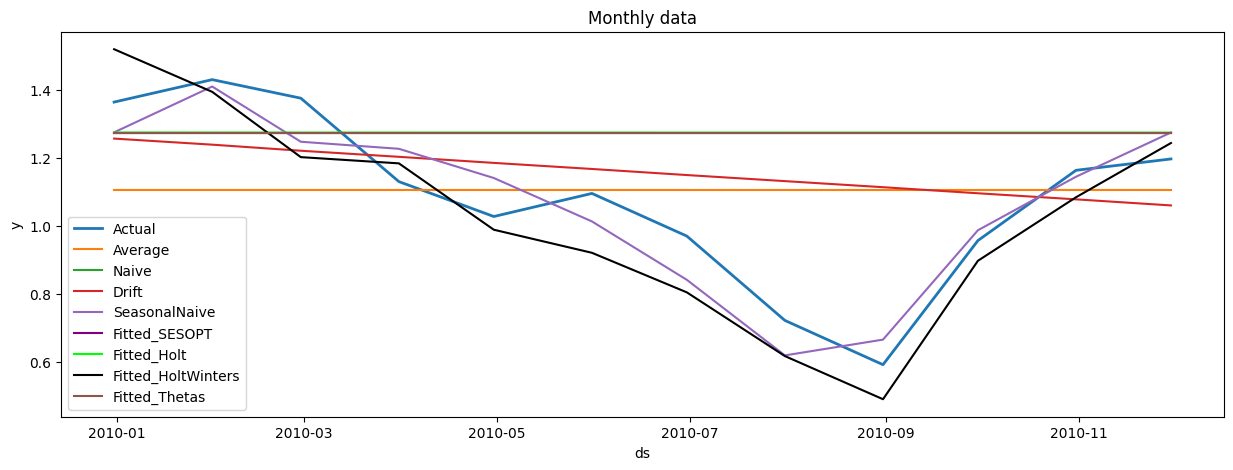

In [364]:
#Plot the actuals vs. fitted values for all SES Optimized, Holt's and Holt-Winter's models
plt.figure(figsize=(15,5))

#Actual data
sns.lineplot(data=test_df, x="ds", y="y", label="Actual", linewidth=2)

#Actual data
sns.lineplot(data=Y_hat, x="ds", y="Average", label="Average")

#Actual data
sns.lineplot(data=Y_hat, x="ds", y="Naive", label="Naive")

#Actual data
sns.lineplot(data=Y_hat, x="ds", y="Drift", label="Drift")

#Actual data
sns.lineplot(data=Y_hat, x="ds", y="SeasonalNaive", label="SeasonalNaive")

#SES Optimized model fitted values
sns.lineplot(data=Y_hat,x="ds", y="SESOpt", label="Fitted_SESOPT", color="purple" )

#Holt's model fitted values
sns.lineplot(data=Y_hat, x="ds", y="Holt", label="Fitted_Holt", color="lime")

#Holt-Winter's model fitted values
sns.lineplot(data=Y_hat, x="ds", y="HoltWinters", label="Fitted_HoltWinters",color="black")

#Theta
sns.lineplot(data=Y_hat, x="ds", y="Theta", label="Fitted_Thetas")

#Add title and show
plt.title("Monthly data");
plt.show()

In [365]:
#Get the actual 12 month values of forecast duration
actual_ts = test_df["y"]

#Create a list with the model aliases
model_names = [str(model) for model in models]

#Initialize error dataframe
error_df = pd.DataFrame(columns=model_names, index=["MAE","MAPE","MSE","RMSE"])

#Print the errors for each model
for model in model_names:

    #Evaluate the model MAE
    model_mae = np.round(mean_absolute_error(actual_ts, Y_hat[model]),2)

    #Evaluate the model MAPE
    model_mape = np.round(100*mean_absolute_percentage_error(actual_ts, Y_hat[model]),2)

    #Evaluate the model MSE
    model_mse = np.round(mean_squared_error(actual_ts, Y_hat[model]),2)

    #Evaluate the model RMSE
    model_rmse = np.round(math.sqrt(mean_squared_error(actual_ts, Y_hat[model])),2)

    #Save errors in error dataframe
    error_df.loc[:,model] = (model_mae, model_mape, model_mse, model_rmse)

In [366]:
#Printing the evaluation metrics
error_df

,Average,Naive,Drift,SeasonalNaive,SESOpt,Holt,HoltWinters,Theta
MAE,0.19,0.25,0.19,0.08,0.25,0.25,0.1,0.25
MAPE,21.2,29.29,21.52,7.98,29.21,29.26,9.74,29.21
MSE,0.06,0.1,0.05,0.01,0.09,0.1,0.01,0.09
RMSE,0.24,0.31,0.23,0.09,0.31,0.31,0.11,0.31


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-17.802, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=23.383, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-22.077, Time=0.48 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-9.946, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=150.666, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-6.798, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-23.471, Time=1.05 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-21.783, Time=1.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-23.779, Time=0.75 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-14.220, Time=0.33 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-21.678, Time=1.03 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-18.141, Time=0.93 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-19.782, Time=2.72 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-22.425, Time=1.13 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept  

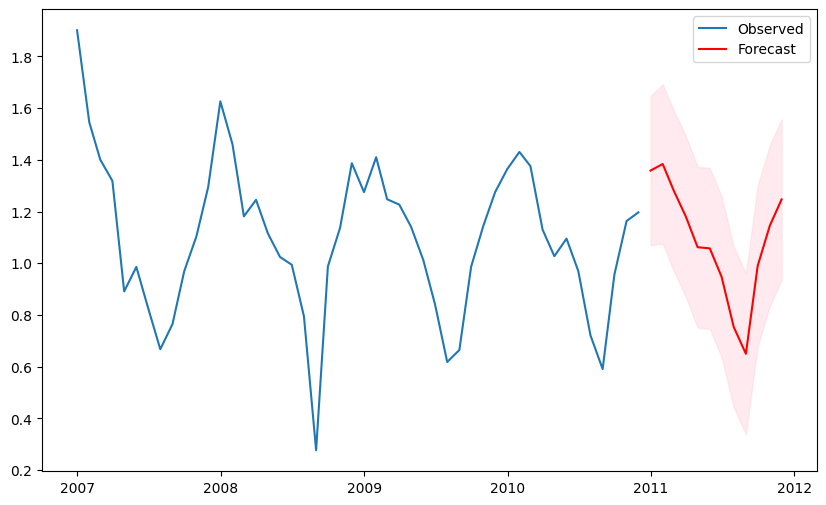

In [367]:
#Fit AUTO ARIMA model to the 'Global_active_power' time series data
auto_arima_model = pm.auto_arima(df_monthly['Global_active_power'],
                                 seasonal=True,
                                 m=12,
                                 stepwise=True,
                                 trace=True)

# Forecasting for the next 12 periods
n_periods = 12
auto_arima_forecast, conf_int = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Plotting the observed data and the forecast
plt.figure(figsize=(10, 6))

# Plot the observed data
plt.plot(df_monthly['Global_active_power'], label='Observed')

# Generate forecast index for the forecasted periods
forecast_index = pd.date_range(start=df_monthly.index[-1], periods=n_periods + 1, freq='M')[1:]

# Plot the forecasted values
plt.plot(forecast_index, auto_arima_forecast, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)

# Add legend to the plot
plt.legend()

# Display the plot
plt.show()

Akaike information criterion (AIC): It is an estimator for finding the best suited paramter for the model.

Less the AIC value better the parameters for the model.

Despite the Auto-Arima's best paramters (1, 0, 0) we tried with different other paramters and found that (1, 0, 1) is the best among all. Also the above ACF and PACF plots justifies the paramters.

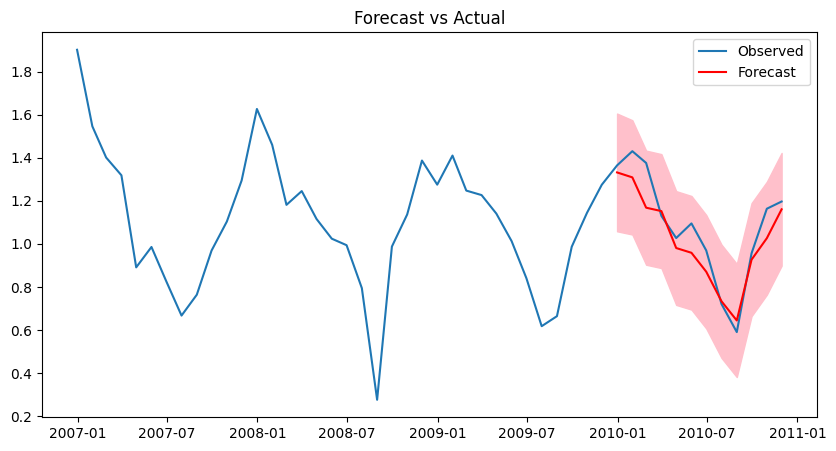

In [368]:
#Forecast vs Actual Plot

df_monthly.index = pd.to_datetime(df_monthly.index)
df_monthly = df_monthly.asfreq('M')

# Parameters to be defined or found via Auto ARIMA
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 12

# Split data into train and test
train = df_monthly['Global_active_power'][:-12]  # all data except last 12 months
test = df_monthly['Global_active_power'][-12:]  # last 12 months

# Fit SARIMAX model
model = sm.tsa.statespace.SARIMAX(train,
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s),
                                  enforce_stationarity=False)
results = model.fit()

# Forecast
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(df_monthly['Global_active_power'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='r')
plt.fill_between(forecast_mean.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()




In [369]:
mae = mean_absolute_error(test, forecast_mean)
mape = mean_absolute_percentage_error(test, forecast_mean)
mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)

# Store SARIMA results in Y_hat for comparison
Y_hat = {'SARIMA': forecast_mean}

# Assuming actual_ts and other models' forecasts (Y_hat) are already defined
# Assuming test_df["y"] contains the actual values for the forecast period

# Initialize error dataframe
model_names = [str(model) for model in models] + ['SARIMA']

# Calculate and store errors for SARIMA
error_df.loc[:, 'SARIMA'] = [np.round(mae, 2), np.round(100 * mape, 2), np.round(mse, 2), np.round(rmse, 2)]


# Print the error dataframe for comparison
print(error_df)

error_df1 = error_df

     Average  Naive  Drift SeasonalNaive SESOpt   Holt HoltWinters  Theta  \
MAE     0.19   0.25   0.19          0.08   0.25   0.25         0.1   0.25   
MAPE    21.2  29.29  21.52          7.98  29.21  29.26        9.74  29.21   
MSE     0.06    0.1   0.05          0.01   0.09    0.1        0.01   0.09   
RMSE    0.24   0.31   0.23          0.09   0.31   0.31        0.11   0.31   

      SARIMA  
MAE     0.08  
MAPE    6.98  
MSE     0.01  
RMSE    0.10  


In [370]:
error_df1

,Average,Naive,Drift,SeasonalNaive,SESOpt,Holt,HoltWinters,Theta,SARIMA
MAE,0.19,0.25,0.19,0.08,0.25,0.25,0.1,0.25,0.08
MAPE,21.2,29.29,21.52,7.98,29.21,29.26,9.74,29.21,6.98
MSE,0.06,0.1,0.05,0.01,0.09,0.1,0.01,0.09,0.01
RMSE,0.24,0.31,0.23,0.09,0.31,0.31,0.11,0.31,0.10


##PROPHET Model

In [371]:
series_prophet = df_monthly['Global_active_power'].reset_index()


series["ds"] = pd.to_datetime(series["ds"],format="%b-%y")

series_prophet.columns = ["ds","y"]
series_prophet.head()

,ds,y
0,2006-12-31,1.901295
1,2007-01-31,1.546034
2,2007-02-28,1.401084
3,2007-03-31,1.318627
4,2007-04-30,0.891189


In [372]:
#Splitting the data into train and test
series_prophet_train = series_prophet[:-12]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvzr7j9c5/tfo46ewn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvzr7j9c5/49532m1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77861', 'data', 'file=/tmp/tmpvzr7j9c5/tfo46ewn.json', 'init=/tmp/tmpvzr7j9c5/49532m1w.json', 'output', 'file=/tmp/tmpvzr7j9c5/prophet_modelh7_phj0s/prophet_model-20240620213946.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:39:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:39:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


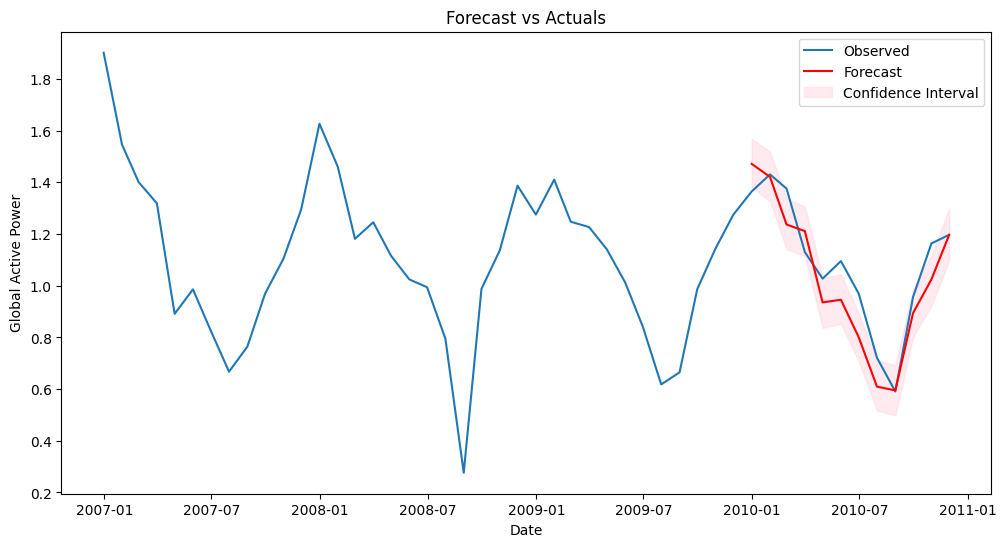

In [373]:
# Prepare the data for Prophet
series_prophet = df_monthly['Global_active_power'].reset_index()

# Rename columns to 'ds' for date and 'y' for values
series_prophet.columns = ["ds", "y"]

# Convert 'ds' to datetime
series_prophet["ds"] = pd.to_datetime(series_prophet["ds"], format="%Y-%m-%d")

# Split the data into training and testing sets
# Use all but the last 12 months for training
series_prophet_train = series_prophet[:-12]
series_prophet_test = series_prophet[-12:]

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(series_prophet_train)

# Create a DataFrame for future predictions (next 12 months)
future = model.make_future_dataframe(periods=12, freq='M')

# Make predictions
forecast = model.predict(future)

# Plot the actual vs. forecasted values for the last 12 months
plt.figure(figsize=(12, 6))

# Plot the actual values for the entire period
plt.plot(series_prophet['ds'], series_prophet['y'], label='Observed')

# Highlight the forecasted period
plt.plot(forecast['ds'][-12:], forecast['yhat'][-12:], label='Forecast', color='red')
plt.fill_between(forecast['ds'][-12:],
                 forecast['yhat_lower'][-12:],
                 forecast['yhat_upper'][-12:],
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.title('Forecast vs Actuals')
plt.show()

In [374]:
# Merge actual and forecasted values
merged_df = series_prophet.set_index('ds').join(forecast.set_index('ds')[['yhat']], how='left')
merged_df = merged_df.dropna()  # Drop rows where yhat is NaN

# Calculate residuals
merged_df['residuals'] = merged_df['y'] - merged_df['yhat']

# Calculate error metrics
prophetmae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
prophetmse = mean_squared_error(merged_df['y'], merged_df['yhat'])
prophetrmse = prophetmse ** 0.5
prophetmape = (abs(merged_df['residuals'] / merged_df['y'])).mean() * 100

print(f"MAE: {prophetmae}")
print(f"MSE: {prophetmse}")
print(f"RMSE: {prophetrmse}")
print(f"MAPE: {prophetmape}%")



MAE: 0.0652331118585519
MSE: 0.006949738151685144
RMSE: 0.08336508952604288
MAPE: 6.7283619594926405%


#5. TIME SERIES CROSS-VALIDATION

In [375]:
!pip install prophet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Store metrics for each model
model_names = ['Naive', 'Drift', 'SeasonalNaive', 'SES', 'Holt', 'HoltWinters', 'Theta', 'SARIMA']
cross_val_results = {model: [] for model in model_names}

# Perform expanding window cross-validation
n_splits = 3
split_size = len(df_monthly) // (n_splits + 1)

for i in range(n_splits):
    train = df_monthly.iloc[:split_size * (i + 1)]
    test = df_monthly.iloc[split_size * (i + 1):split_size * (i + 2)]

    # Naive
    naive_forecast = train['Global_active_power'].iloc[-1]
    cross_val_results['Naive'].append(mean_absolute_error(test['Global_active_power'], [naive_forecast] * len(test)))

    # Drift
    drift_forecast = train['Global_active_power'].iloc[-1] + (np.arange(len(test)) + 1) * ((train['Global_active_power'].iloc[-1] - train['Global_active_power'].iloc[0]) / (len(train)-1))
    cross_val_results['Drift'].append(mean_absolute_error(test['Global_active_power'], drift_forecast))

    # Seasonal Naive (assuming seasonality of 12)
    seasonal_naive_forecast = train['Global_active_power'].iloc[-12:].values.tolist() * (len(test) // 12 + 1)
    seasonal_naive_forecast = seasonal_naive_forecast[:len(test)]
    cross_val_results['SeasonalNaive'].append(mean_absolute_error(test['Global_active_power'], seasonal_naive_forecast))

    # SES
    ses_model = ExponentialSmoothing(train['Global_active_power'], trend=None, seasonal=None).fit()
    ses_forecast = ses_model.forecast(len(test))
    cross_val_results['SES'].append(mean_absolute_error(test['Global_active_power'], ses_forecast))

    # Holt
    holt_model = Holt(train['Global_active_power']).fit()
    holt_forecast = holt_model.forecast(len(test))
    cross_val_results['Holt'].append(mean_absolute_error(test['Global_active_power'], holt_forecast))

    # Holt-Winters (assuming seasonality of 12)
    if len(train) >= 24:  # Ensure there are at least 24 months of data
        hw_model = ExponentialSmoothing(train['Global_active_power'], seasonal_periods=12, trend='add', seasonal='add').fit()
        hw_forecast = hw_model.forecast(len(test))
        cross_val_results['HoltWinters'].append(mean_absolute_error(test['Global_active_power'], hw_forecast))
    else:
        cross_val_results['HoltWinters'].append(np.nan)

    # Theta (simplified version using SES as a proxy)
    theta_model = ExponentialSmoothing(train['Global_active_power'], trend=None, seasonal=None).fit()
    theta_forecast = theta_model.forecast(len(test))
    cross_val_results['Theta'].append(mean_absolute_error(test['Global_active_power'], theta_forecast))

    # SARIMA
    try:
        sarima_model = SARIMAX(train['Global_active_power'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit(disp=False)
        sarima_forecast = sarima_model.forecast(steps=len(test))
        cross_val_results['SARIMA'].append(mean_absolute_error(test['Global_active_power'], sarima_forecast))
    except Exception as e:
        print(f"Error in fold {i+1}: {e}")
        cross_val_results['SARIMA'].append(np.nan)



# Calculate average MAE for each model
average_mae = {model: np.mean([score for score in scores if not np.isnan(score)]) for model, scores in cross_val_results.items()}

for model in model_names:
    print(f"{model} cross-validated MAE scores:", cross_val_results[model])
    print(f"Average MAE for {model}:", average_mae[model])

Naive cross-validated MAE scores: [0.29029245006916005, 0.32068800786190854, 0.24737077709563768]
Average MAE for Naive: 0.28611707834223543
Drift cross-validated MAE scores: [0.2632679639230987, 0.20936948751404058, 0.18599602820901065]
Average MAE for Drift: 0.2195444932153833
SeasonalNaive cross-validated MAE scores: [0.15361107240008723, 0.11341179711535643, 0.08026414149979584]
Average MAE for SeasonalNaive: 0.11576233700507982
SES cross-validated MAE scores: [0.2902924486493611, 0.32068800475380654, 0.2473707761251457]
Average MAE for SES: 0.2861170765094378
Holt cross-validated MAE scores: [1.4671953541225393, 1.2910294073897344, 0.6330318048927017]
Average MAE for Holt: 1.1304188554683252
HoltWinters cross-validated MAE scores: [nan, 0.0969694800299788, 0.09766204207716901]
Average MAE for HoltWinters: 0.0973157610535739
Theta cross-validated MAE scores: [0.2902924486493611, 0.32068800475380654, 0.2473707761251457]
Average MAE for Theta: 0.2861170765094378
SARIMA cross-validate

In [376]:
!pip install prophet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

# Store metrics for Prophet model
prophet_cross_val_results = []

# Perform expanding window cross-validation
n_splits = 3
split_size = len(df_monthly) // (n_splits + 1)

for i in range(n_splits):
    train = df_monthly.iloc[:split_size * (i + 1)]
    test = df_monthly.iloc[split_size * (i + 1):split_size * (i + 2)]

    try:
        # Prepare the data for Prophet
        train_prophet = train.reset_index().rename(columns={'DateTime': 'ds', 'Global_active_power': 'y'})
        test_prophet = test.reset_index().rename(columns={'DateTime': 'ds', 'Global_active_power': 'y'})

        # Initialize and fit the Prophet model
        prophet_model = Prophet()
        prophet_model.fit(train_prophet)

        # Make future DataFrame and predictions
        future = prophet_model.make_future_dataframe(periods=len(test), freq='M')
        forecast = prophet_model.predict(future)

        # Extract the forecast for the test period
        prophet_forecast = forecast.set_index('ds').loc[test_prophet['ds'], 'yhat']
        prophet_cross_val_results.append(mean_absolute_error(test['Global_active_power'], prophet_forecast))
    except Exception as e:
        print(f"Error in fold {i+1} for Prophet: {e}")
        prophet_cross_val_results.append(np.nan)

# Calculate average MAE for Prophet model
average_mae_prophet = np.mean([score for score in prophet_cross_val_results if not np.isnan(score)])

print(f"Prophet cross-validated MAE scores:", prophet_cross_val_results)
print(f"Average MAE for Prophet:", average_mae_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvzr7j9c5/2htjyek3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvzr7j9c5/rzjxi541.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46233', 'data', 'file=/tmp/tmpvzr7j9c5/2htjyek3.json', 'init=/tmp/tmpvzr7j9c5/rzjxi541.json', 'output', 'file=/tmp/tmpvzr7j9c5/prophet_model5hvszala/prophet_model-20240620214017.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:40:17 - cmdstanpy - INFO - Chain [1] start processing
IN

Prophet cross-validated MAE scores: [0.6855708383667342, 0.2829627399283218, 0.0886937348224487]
Average MAE for Prophet: 0.35240910437250156


#6. RESIDUAL DIAGNOSTICS

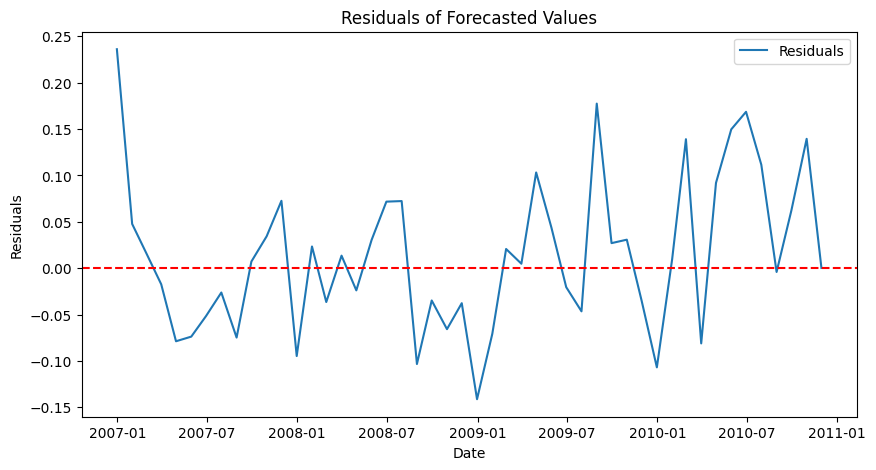

In [377]:
# Plot residuals

prophet_residuals = merged_df['residuals']

plt.figure(figsize=(10, 5))
plt.plot(merged_df.index, prophet_residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Forecasted Values')
plt.legend()
plt.show()

<Axes: ylabel='Density'>

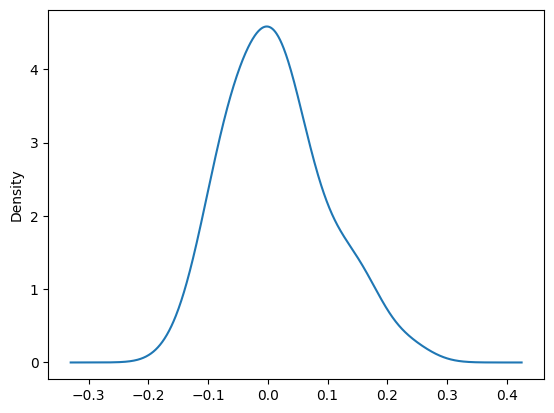

In [378]:
prophet_residuals.plot(kind='kde')

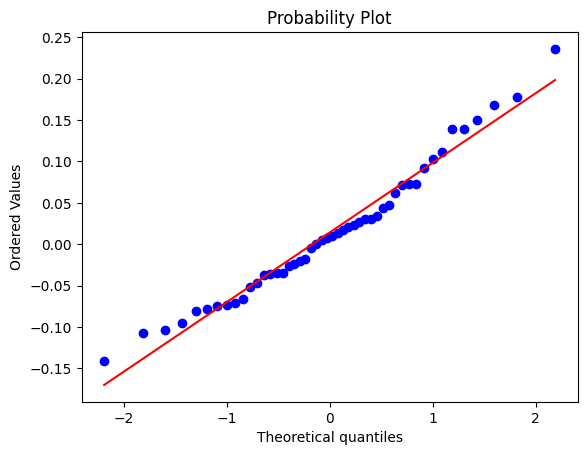

In [379]:
stats.probplot(prophet_residuals,dist="norm", plot=pylab)
pylab.show()

#7. ERROR REPORTING

In [380]:

print("PROPHET: ")
print(f"MAE: {prophetmae}")
print(f"MAPE: {prophetmape}%")
print(f"MSE: {prophetmse}")
print(f"RMSE: {prophetrmse}")


PROPHET: 
MAE: 0.0652331118585519
MAPE: 6.7283619594926405%
MSE: 0.006949738151685144
RMSE: 0.08336508952604288
